# ODE-Solvers From Scratch

All the other tutorials show how to use the ODE-solver with the `probsolve_ivp` function.
This is great, though `probnum` has more customisation to offer.

In [1]:
import probnum.diffeq as pnd
import probnum.filtsmooth as pnfs
import probnum.random_variables as pnrv
import numpy as np

import matplotlib.pyplot as plt
plt.style.use("../probnum.mplstyle")

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


First we define the ODE problem. As always, we use Lotka-Volterra. It is important that `initrv` is an actual random variable. Arrays can be wrapped with `probnum.random_variables.Constant`. 

In [2]:
ivp = pnd.lotkavolterra([0., 20.], initrv=pnrv.Constant(np.array([20., 20.])))


Next, we define a prior distribution and a measurement model. The former allows any `Integrator`, which currently restricts the choice to `IBM`, `IOUP`, and `Matern`. 
The measurement model requires a choice between EK0, EK1 (extended Kalman filters of order 0 or 1, respectively) and UK (unscented Kalman filter). 
After this choice is made, each of those classes offer a constructor that defines the model directly from the initial value problem, e.g. `DiscreteUKFComponent.from_ode(ivp, prior, evlvar)`. `evlvar` is usually zero. The prior is the `Integrator` chosen above.  

In [3]:
prior = pnfs.statespace.IBM(ordint=4, spatialdim=ivp.dimension, diffconst=1.)
ekf = pnfs.DiscreteEKFComponent.from_ode(ivp, prior, np.zeros((2, 2)), ek0_or_ek1=0)


Next, we turn this into a `Kalman` object which will do all the heavy lifting for the ODE solver. To this end, we need to define an initial distribution. In `probsolve_ivp`, this is automatised by using as many derivatives as the `IVP` object allows (max. 2). 

This time, assume that some bird told us about the real derivatives of the initial values (*stay tuned for more on this*). This can be used to define a more robust ODE solver.

In [4]:
initial_values = np.array([
    20.,
    -10.,
    -5.,
    17.5,
    8.75,
    20.,
    10.,
    -5.,
    -17.5,
    8.75,
])
initrv = pnrv.Normal(initial_values, np.zeros((len(initial_values), len(initial_values))))
kalman = pnfs.Kalman(prior, ekf, initrv)

In [5]:
solver = pnd.GaussianIVPFilter(ivp, kalman, with_smoothing = True)

Now we can solve the ODE. To this end, define a `StepRule`, e.g. `ConstantSteps` or `AdaptiveSteps`. 

In [6]:
steprule = pnd.ConstantSteps(0.1)
odesol = solver.solve(firststep=0.1, steprule=steprule)

`GaussianIVPFilter.solve` returns an `ODESolution` object, which is sliceable and callable. The latter can be used to plot the solution on a uniform grid, even though the solution was computed on an adaptive grid. Be careful: the return values of `__call__`, etc., are always random variable-like objects. We decide to plot the mean.

In [7]:
evalgrid = np.arange(ivp.t0, ivp.tmax, step=0.1)
y = odesol(evalgrid).mean

Et voila: this is the solution to the Lotka-Volterra model.

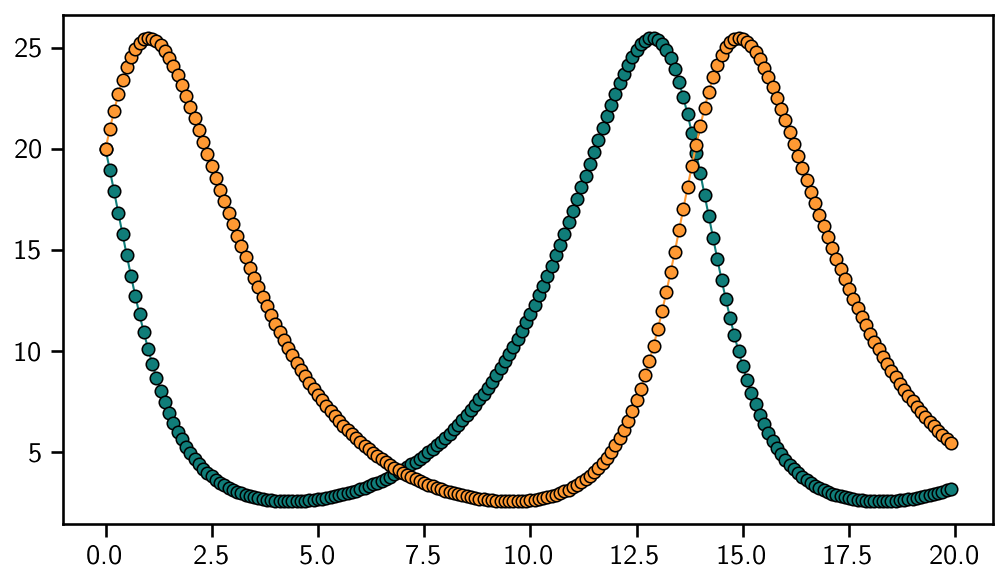

In [8]:
plt.plot(evalgrid, y, "o-", linewidth=1)
plt.show()